In [33]:
LM = readRDS("/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/in_vivo_comparison/sce_lamanno_embryo.Rds")

In [34]:
LM

class: SingleCellExperiment 
dim: 19531 1977 
metadata(0):
assays(1): counts
rownames(19531): DDX11L1 WASH7P_p1 ... VAMP7_loc1 DDX11L16_loc1
rowData names(0):
colnames(1977): 1772067_089_A01 1772067_089_A02 ... 1772122_224_H10
  1772122_224_H12
colData names(3): Cell_ID Cell_type Timepoint
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [35]:
LM$Cell_type = as.character(LM$Cell_type)
unique(LM$Cell_type)

[1] "hMgl"     "hRgl2a"   "Unk"      "hNProg"   "hProgBP"  "hProgM"  
 [7] "hOMTN"    "hDA0"     "hNbM"     "hProgFPL" "hEndo"    "hProgFPM"
[13] "hRgl2b"   "hNbML5"   "hRgl3"    "hRN"      "hPeric"   "hDA1"    
[19] "hRgl1"    "hGaba"    "hDA2"     "hSert"    "hNbGaba"  "hNbML1"  
[25] "hRgl2c"   "hOPC"

In [36]:
LM = LM[,LM$Cell_type %in% c('hDA0','hDA1','hDA2','hSert','hGaba')]

In [37]:
LM <- scater::logNormCounts(LM, log=T)
alt.fit2 <- scran::trendVar(LM, use.spikes = FALSE)
alt.decomp2 <- scran::decomposeVar(LM, alt.fit2)

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [38]:
genes_LM = rownames(alt.decomp2[order(alt.decomp2$bio, decreasing = TRUE),][1:2000,])

In [39]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_neuroseq/in_vivo_comparison/"

In [40]:
neuroseq_filename = paste0(mydir,"neuroseq_all_25pct_sce.Rds")
neuroseq = readRDS(neuroseq_filename)

In [41]:
neuroseq = neuroseq[,neuroseq$celltype %in% c('DA','Sert','CHem')]

In [42]:
neuroseq <- scater::logNormCounts(neuroseq, log=T)
design <- model.matrix(~pool_id, data = colData(neuroseq))
alt.fit <- scran::trendVar(neuroseq, design = design, use.spikes = FALSE)
alt.decomp <- scran::decomposeVar(neuroseq, alt.fit)

Warning message:
“'trendVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'decomposeVar' is deprecated.
Use 'modelGeneVar' instead.
See help("Deprecated")”Warning message:
“'testVar' is deprecated.
See help("Deprecated")”

In [43]:
genes_neuroseq = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:2000,])

In [44]:
all_genes = unique(c(genes_LM,genes_neuroseq))

In [45]:
genes_n = rownames(neuroseq)[rownames(neuroseq) %in% all_genes]
common_genes = rownames(LM)[rownames(LM) %in% genes_n]

In [46]:
length(common_genes)

[1] 3244

In [47]:
query = neuroseq[common_genes,]
reference = LM[common_genes,]

In [48]:
query$batch_factor = "query"
reference$batch_factor = "reference"

In [49]:
getJointPCA = function(reference, query, 
                       assayNameRef = "logcounts",
                       assayNameQuery = "logcounts") {
# reference and query are SingleCellExperiment objects
  all_assay = cbind(assay(query, assayNameQuery),
                    assay(reference, assayNameRef))
# batch factors can be dataset specific batches or just a factor labelling i.e. "query", "reference" 
#   batchFactor = factor(c(as.character(query$sample_id),
#                            as.character(reference$dataset)))
 batchFactor = factor(c(as.character(query$batch_factor),
                           as.character(reference$batch_factor)))
#   print(table(batchFactor))
  mbpca = batchelor::multiBatchPCA(all_assay,
                        batch = batchFactor,
                        d = 50
                        # BPPARAM = BiocParallel::MulticoreParam(workers = 4)
  )
  print("done multibatch PCA")
  dim(mbpca[[1]])
  out = do.call(batchelor::reducedMNN, mbpca)
  print("done batch correction")
  joint_mnn_pca = out$corrected
  return(joint_mnn_pca)
}

In [50]:
joint_mnn_pca = getJointPCA(reference, query)

Warning message in sweep(centered, 2, w, "/", check.margin = FALSE):
“'check.margin' is ignored when 'x' is a DelayedArray object or
  derivative”

[1] "done multibatch PCA"
[1] "done batch correction"


In [51]:
df_pca = as.data.frame(joint_mnn_pca[,c(1:2)])
colnames(df_pca) = paste0("PC",1:2)
head(df_pca)

,PC1,PC2
TAGAGCTAGCGTAATA-1-6,15.571807,2.2514006
CATGACAGTGTGCCTG-1-6,9.315268,-10.2538368
ACAGCCGGTATATCCG-1-6,12.832951,0.3744284
GGGCACTCAAAGCGGT-1-6,17.220548,3.7737447
GATGCTATCCTTCAAT-1-6,5.876969,-16.6899402
TTGGCAATCAGCATGT-1-6,14.045763,-3.4233800


In [53]:
mat = matrix(0, nrow = length(unique(query$celltype)), ncol = length(unique(reference$Cell_type)))
nrow(mat)
ncol(mat)

[1] 3

[1] 5

In [54]:
rownames(mat) = unique(query$celltype)
colnames(mat) = unique(reference$Cell_type)

In [55]:
i = 0
for (celltype in unique(query$celltype)){
#     print(celltype)
    j = 0
    i = i+1
    sel_cells = colnames(query[,query$celltype == celltype])
    closest_atlas_cell_ind = BiocNeighbors::queryKNN(
        joint_mnn_pca[colnames(reference),],
        joint_mnn_pca[sel_cells,],
        k = 1, get.index = TRUE, get.distance = FALSE)
    mapped_cells = colnames(reference)[closest_atlas_cell_ind$index]
    for (cluster in unique(reference$Cell_type)){
#         print(cluster)
        j = j+1
        n = length(mapped_cells[mapped_cells %in% colnames(reference[,reference$Cell_type == cluster])])
        mat[i,j] = n/length(mapped_cells)
#         print(mat[i,j])
    }
}

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

In [56]:
mat

,hDA0,hDA1,hGaba,hDA2,hSert
Sert,0.92562836,0.01957006,0.005021443,0.01161718,0.03816297
DA,0.08553404,0.10851985,0.009127210,0.17090031,0.62591859
CHem,0.13608795,0.01791130,0.044162244,0.07211903,0.72971948


In [57]:
library(reshape2)
mat_melt = melt(mat)
head(mat_melt)

Var1,Var2,value
Sert,hDA0,0.92562836
DA,hDA0,0.08553404
CHem,hDA0,0.13608795
Sert,hDA1,0.01957006
DA,hDA1,0.10851985
CHem,hDA1,0.01791130


In [58]:
library(ggplot2)

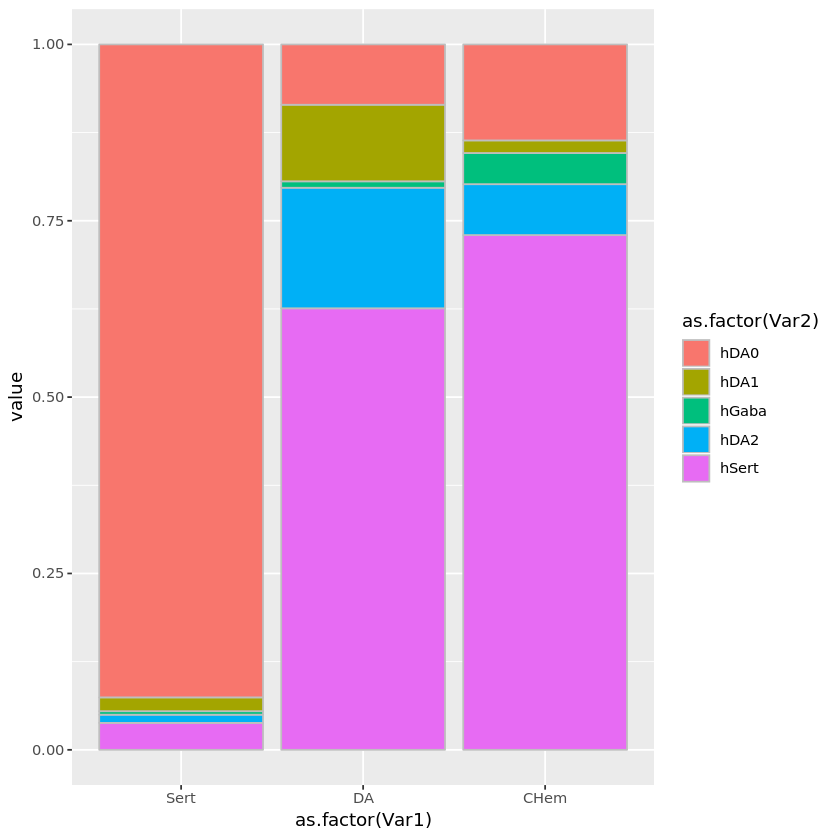

In [59]:
df = as.data.frame(mat_melt)
ggplot(df, aes(x = as.factor(Var1), y = value, fill = as.factor(Var2))) + geom_bar(stat="identity", col = "grey")

In [76]:
# sel_cells = colnames(neuroseq[,neuroseq$celltype == 'DA'])
sel_cells = colnames(neuroseq[,neuroseq$celltype == 'DA' & neuroseq$time_point == 'D30' & 
                             neuroseq$treatment == 'NONE'])

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
“subscript is an array, passing it thru as.vector() first”

In [77]:
closest_atlas_cell_ind = BiocNeighbors::queryKNN(
    joint_mnn_pca[colnames(LM),],
    joint_mnn_pca[sel_cells,],
  k = 1, get.index = TRUE, get.distance = FALSE)

In [78]:
mapped_cells = colnames(LM)[closest_atlas_cell_ind$index]

In [79]:
df = as.data.frame(colData(LM))
head(df,2)

,Cell_ID,Cell_type,Timepoint
1772067_089_B06,1772067_089_B06,hDA0,week_7
1772071_027_C04,1772071_027_C04,hDA1,week_7


In [80]:
df_mapped = df[mapped_cells,]
head(df_mapped,2)
nrow(df_mapped)
nrow(df_mapped[df_mapped$Cell_type == 'hDA0',])
nrow(df_mapped[df_mapped$Cell_type == 'hDA1',])
nrow(df_mapped[df_mapped$Cell_type == 'hDA2',])
nrow(df_mapped[df_mapped$Cell_type == 'hSert',])
nrow(df_mapped[df_mapped$Cell_type == 'hGaba',])

,Cell_ID,Cell_type,Timepoint
1772121_283_D09,1772121_283_D09,hDA2,week_10
1772122_318_D10,1772122_318_D10,hDA0,week_6


[1] 13799

[1] 1703

[1] 1241

[1] 4105

[1] 6514

[1] 236

In [81]:
lm_clusters = as.character(unique(LM$Cell_type))

In [82]:
for (cluster in lm_clusters){
    n = length(mapped_cells[mapped_cells %in% rownames(df[df$Cell_type == cluster,])])
    if (n/length(mapped_cells) > 0.01){
        print(c(cluster, n, n/length(mapped_cells)))
    }
}

[1] "hDA0"              "1703"              "0.123414740198565"
[1] "hDA1"               "1241"               "0.0899340531922603"
[1] "hGaba"              "236"                "0.0171026886006232"
[1] "hDA2"              "4105"              "0.297485325023552"
[1] "hSert"             "6514"              "0.472063192984999"


In [ ]:
for (celltype in unique(query$celltype)){
    closest_atlas_cell_ind = BiocNeighbors::queryKNN(
        joint_mnn_pca[colnames(LM),],
        joint_mnn_pca[sel_cells,],
  k = 1, get.index = TRUE, get.distance = FALSE)
    for (cluster in lm_clusters){
    n = length(mapped_cells[mapped_cells %in% rownames(df[df$Cell_type == cluster,])])
    if (n/length(mapped_cells) > 0.01){
        print(c(cluster, n, n/length(mapped_cells)))
        }
    }
}